# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [2]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на изображения:

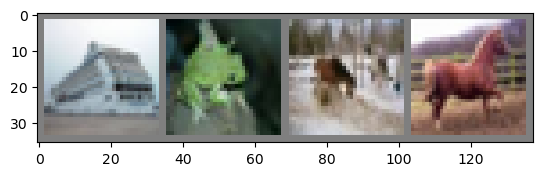

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.shortcut = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=1),
            nn.BatchNorm2d(32)
        )
        
        self.avgpool = nn.AvgPool2d(8)
        
        self.fc = nn.Linear(32 * 4 * 4, n_classes)
        
    def forward(self, x):
        out = self.relu(self.bn2(self.conv2(self.relu(self.bn1(self.conv1(x))))) + self.shortcut(x))
                
        out = self.fc(self.avgpool(out).view(-1, 32 * 4 * 4))
        
        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (avgpool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else 'cpu'))

print(device)

mps


In [9]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [10]:
import plotly.express as px
import pandas as pd

def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    data = pd.DataFrame({
        "epoch": list(range(1, len(train_losses) + 1)),
        "train loss": train_losses,
        "val loss": val_losses,
        "train accuracy": train_metrics,
        "val accuracy": val_metrics
    })
    
    loss_fig = px.line(
        data, 
        x="epoch", 
        y=["train loss", "val loss"], 
    )
    
    loss_fig.update_layout(
        yaxis_title="loss"
    )
    
    metric_fig = px.line(
        data, 
        x="epoch", 
        y=["train accuracy", "val accuracy"], 
    )
    
    metric_fig.update_layout(
        yaxis_title="accuracy"
    )
        
    return loss_fig, metric_fig

def binned_avg(arr, n=20):
    bin_size = len(arr) // n
    return [np.mean(arr[i * bin_size: (i + 1) * bin_size]) for i in range(n)]

In [11]:
from tqdm.notebook import tqdm
import wandb

def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    criterion = torch.nn.CrossEntropyLoss()
    
    for data, target in tqdm(loader, desc="Testing", leave=False):
        
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        loss = criterion(output, target)
        
        _, predicted = torch.max(output, 1)
        acc = (predicted == target).float().mean()
        
        loss_log.append(loss.item())
        acc_log.append(acc.item())
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    criterion = torch.nn.CrossEntropyLoss()
        
    for data, target in tqdm(train_loader, desc="Training", leave=False):
        
        data, target = data.to(device), target.to(device)
            
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(output, 1)
        acc = (predicted == target).float().mean()
        
        loss_log.append(loss.item())
        acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None, pass_loss=False, logall=False):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if logall:
            
            loss_fig, metric_fig = plot_losses(
                binned_avg(train_loss_log, n=epoch+1),
                binned_avg(train_acc_log, n=epoch+1),
                val_loss_log,
                val_acc_log
            )
            
            wandb.log({
                "loss": loss_fig,
                "accuracy": metric_fig,
            })
        
        if scheduler is not None:
            
            print(f" lr: {scheduler.get_last_lr()}\n")
            
            if logall:
                wandb.log({
                    "lr": scheduler.get_last_lr()
                })
                
            if pass_loss:
                scheduler.step(val_loss)
            else:
                scheduler.step()
                
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [27]:
wandb.init(
    project="dl_hw_2",
    name="2.1",
    config = {"optim": "Adam", "lr": 0.1, "momentum": 0.9, "n_epochs": 20}
)

In [28]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, \
                                                                train_loader, val_loader, logall=True)

  0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.4793108643953718, train acc: 0.47317347873063587
 val loss: 1.2516516741285932, val acc: 0.5616134752618506



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.1638668308092428, train acc: 0.5934072212065814
 val loss: 1.070127946772474, val acc: 0.6240026595744681



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.0470261802621037, train acc: 0.6353078480176559
 val loss: 1.0034843368733184, val acc: 0.6486258866939139



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 0.9812808619774673, train acc: 0.6631708671449525
 val loss: 1.0253439583676927, val acc: 0.644038120736467



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 0.9511489604465269, train acc: 0.6700835728122285
 val loss: 0.9714750528335572, val acc: 0.6689937944107868



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 0.9160526844875468, train acc: 0.6811177853692384
 val loss: 0.9275066804378591, val acc: 0.6823581561129144



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 0.8873521798925382, train acc: 0.6905850091407678
 val loss: 0.9469165063918905, val acc: 0.6690381207364671



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 0.8677640026622542, train acc: 0.6989708475264597
 val loss: 0.9039389513908549, val acc: 0.6895833335024245



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 0.8537489507054498, train acc: 0.7044838731206096
 val loss: 0.8935434222221375, val acc: 0.6939937944107867



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 0.8356635841852568, train acc: 0.7115271612320783
 val loss: 0.929058362068014, val acc: 0.6792331561129143



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 0.8276800897919063, train acc: 0.7135103813473006
 val loss: 0.9357911099778845, val acc: 0.6775487590343394



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 0.8115839279874805, train acc: 0.7182643967093236
 val loss: 0.9018151255364114, val acc: 0.6932402483960416



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 0.8012621667528937, train acc: 0.7242385414880198
 val loss: 0.8571480200645771, val acc: 0.7103058510638298



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 0.7875303846172702, train acc: 0.7287028271711723
 val loss: 0.9424558705471932, val acc: 0.6888297872340425



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 0.782052226541683, train acc: 0.7300331352833638
 val loss: 0.9069483929492058, val acc: 0.6916445037151905



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 0.7724690289122531, train acc: 0.7325386850663905
 val loss: 0.8592625146216535, val acc: 0.7090647164811479



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.765907696058371, train acc: 0.7321755028511968
 val loss: 0.9316186209942432, val acc: 0.6926861702127659



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.7521596047516497, train acc: 0.7395085205325697
 val loss: 0.9103664106511055, val acc: 0.6891179079705096



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.7484861795928404, train acc: 0.7382149386885397
 val loss: 0.8811492557221271, val acc: 0.7021276595744681



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.7463726983754683, train acc: 0.7406062288737603
 val loss: 0.8567216666454964, val acc: 0.7144060284533399



In [29]:
wandb.finish()

Посчитайте точность на тестовой выборке:

In [30]:
print(*test(net, test_loader))

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

0.8954869007608693 0.6981488853503185


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

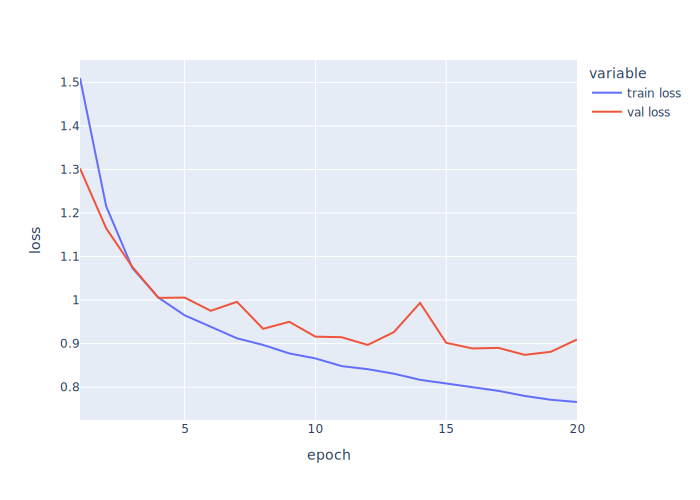

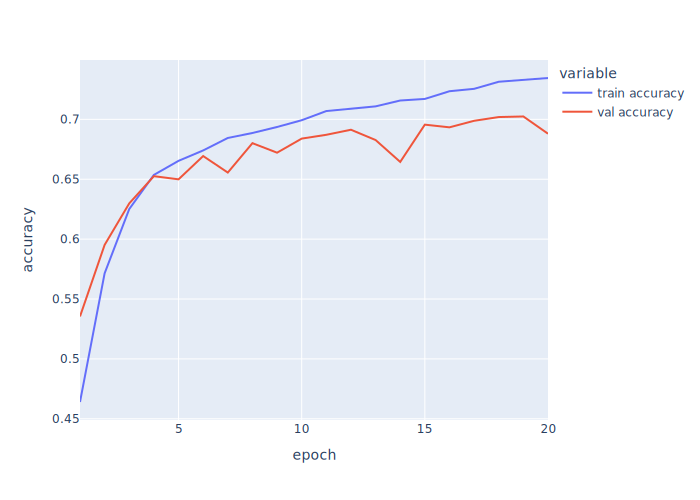

In [16]:
loss_fig, metric_fig = plot_losses(binned_avg(train_loss_log), binned_avg(train_acc_log), \
                                   val_loss_log, val_acc_log)

loss_fig.show(renderer='svg')
metric_fig.show(renderer='svg')

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [17]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

  0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.5255989864931683, train acc: 0.45988671980130824
 val loss: 1.2857310919051474, val acc: 0.5423980497299357

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.2102673649787903, train acc: 0.5778026247373229
 val loss: 1.1692241973065316, val acc: 0.5922429078436913

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.09318827438616, train acc: 0.621845619007264
 val loss: 1.163704341269554, val acc: 0.6000886526513607

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 1.0260480777437115, train acc: 0.6447791525825068
 val loss: 1.0289762362520745, val acc: 0.6445478723404255

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 0.978100011836894, train acc: 0.6604612823814099
 val loss: 1.0348156662697487, val acc: 0.633843085106383

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 0.9464662063056416, train acc: 0.6731114521540933
 val loss: 0.9676887570543492, val acc: 0.6677304965384463

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 0.9251784098213726, train acc: 0.678273537477148
 val loss: 0.952167025779156, val acc: 0.6725177305809995

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 0.9049114419293796, train acc: 0.6848883520968435
 val loss: 0.8984880591960663, val acc: 0.6912455675449777

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 0.8826876975718538, train acc: 0.6946534670249199
 val loss: 0.9083844032693417, val acc: 0.6861037234042553

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 0.8780744592276091, train acc: 0.6965509924417875
 val loss: 0.8744982113229468, val acc: 0.698404255319149

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 0.7631045541772022, train acc: 0.7397737661053101
 val loss: 0.8359753563048992, val acc: 0.7121675531914894

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 0.7478703325801619, train acc: 0.7420344738463379
 val loss: 0.8308598926726808, val acc: 0.7157579787234043

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 0.7444263224845831, train acc: 0.7454336968810729
 val loss: 0.8274131183928631, val acc: 0.7148049646235527

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 0.7378137071346235, train acc: 0.7460172369231689
 val loss: 0.8340224607193724, val acc: 0.7133865249917862

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 0.7348407484604628, train acc: 0.7488206777537763
 val loss: 0.8227755630269964, val acc: 0.716910461161999

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 0.7207529059929647, train acc: 0.75292586190609
 val loss: 0.8193530130893626, val acc: 0.7186835106382978

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.7177365777479447, train acc: 0.7535583703783791
 val loss: 0.8174084224599473, val acc: 0.7186835106382978

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.716499349425872, train acc: 0.7557660290048589
 val loss: 0.8171508316029894, val acc: 0.7177969859001484

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.7172798162949369, train acc: 0.7540807000461837
 val loss: 0.8182170129836874, val acc: 0.7186613476022761

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.7161117370974212, train acc: 0.7553293941443755
 val loss: 0.8174644990170256, val acc: 0.7175310284533399

 lr: [0.0010000000000000002]



Посчитайте точность на тестовой выборке:

In [18]:
print(*test(net, test_loader))

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

0.8371021679252576 0.7169585987261147


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [19]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.7948347020628683, train acc: 0.3689646448470121
 val loss: 1.586826837823746, val acc: 0.4429521276595745



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.5181712629154351, train acc: 0.4648488509371686
 val loss: 1.4446491413928093, val acc: 0.4837322695458189



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.4025608020029294, train acc: 0.5081858840895309
 val loss: 1.37176322125374, val acc: 0.5174867021276596



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 1.326693294689032, train acc: 0.5337106621461551
 val loss: 1.2790200796533138, val acc: 0.5519725178150421



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 1.2708101969968248, train acc: 0.5560484135172703
 val loss: 1.2326613071116996, val acc: 0.5710549646235527



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 1.2209081194300537, train acc: 0.5735382933503314
 val loss: 1.1884481830799833, val acc: 0.5857491135597229



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 1.1763615839224193, train acc: 0.586376175257144
 val loss: 1.1401994796509438, val acc: 0.6027039007937655



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 1.1392021218427137, train acc: 0.6012013580725005
 val loss: 1.1145252762956823, val acc: 0.611192376055616



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 1.1103961396914732, train acc: 0.6135822016970549
 val loss: 1.0742428203846546, val acc: 0.6291666667512122



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 1.0836910052970732, train acc: 0.618915676416819
 val loss: 1.0608121471202119, val acc: 0.6273049646235527



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 1.0645801450042445, train acc: 0.6296315945044731
 val loss: 1.0409872871764163, val acc: 0.6370124114320633



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 1.0402068854250028, train acc: 0.6383642922589722
 val loss: 1.039811674331097, val acc: 0.6361258866939139



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 1.0276052239172202, train acc: 0.6407310982290961
 val loss: 1.017038616221002, val acc: 0.6420434398854032



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 1.0071613677458964, train acc: 0.6507655393053017
 val loss: 1.0134779879387388, val acc: 0.6428634752618506



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 0.9974013233533507, train acc: 0.6528140506971035
 val loss: 0.9888988576036819, val acc: 0.6533244680851064



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 0.9798839808164175, train acc: 0.6593023635569613
 val loss: 1.0048119375046263, val acc: 0.648315602921425



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.9690179084946948, train acc: 0.6646888875002399
 val loss: 0.9923513255220778, val acc: 0.6531471632896586



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.9611112686790104, train acc: 0.6652928310730776
 val loss: 0.963753239398307, val acc: 0.6620789007937654



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.9457875043426179, train acc: 0.6728176416819013
 val loss: 0.9612783462443251, val acc: 0.6624778369639782



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.9405479851762817, train acc: 0.6729155785422875
 val loss: 0.9468039160079145, val acc: 0.666910461161999



Ну да, мы сходимся сильно медленне с тамким `lr`.

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

### `ReduceLROnPlateau`

Уменьшаем `lr`, если модель не улучшается в течении последних `patience` эпох.

In [20]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, \
    train_loader, val_loader, scheduler, True)

  0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.4999662537461442, train acc: 0.46762780755267935
 val loss: 1.3125097061725373, val acc: 0.5406471631628402

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.1959628389783925, train acc: 0.5822546683674102
 val loss: 1.2155352739577598, val acc: 0.5756205675449777

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.0503666494620565, train acc: 0.6333572734862403
 val loss: 1.0730568764057564, val acc: 0.6271719859001484

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 0.9838342383313222, train acc: 0.6586861779310585
 val loss: 1.0146670349100804, val acc: 0.6514627659574468

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 0.9401499137582029, train acc: 0.6745601005484461
 val loss: 0.9870804439199732, val acc: 0.6515070922831272

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 0.9065566650256378, train acc: 0.6850434187561328
 val loss: 1.0281555787045904, val acc: 0.6489140071767442

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 0.8824251810636992, train acc: 0.6939026182704695
 val loss: 0.9763303049067233, val acc: 0.6668661348363186

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 0.8682907360999196, train acc: 0.6999134892083609
 val loss: 0.919514835895376, val acc: 0.6778368795171698

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 0.85083410258267, train acc: 0.7050470097409306
 val loss: 0.928046830410653, val acc: 0.6857047872340426

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 0.8339211317477322, train acc: 0.7120617328439813
 val loss: 0.952126430196965, val acc: 0.6742021276595744

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 0.8218642030272231, train acc: 0.7153466962809101
 val loss: 0.9052638606822238, val acc: 0.6882978723404255

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 0.8135226721955392, train acc: 0.7164729695215521
 val loss: 0.8557761187249041, val acc: 0.707247340425532

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 0.8014860871287107, train acc: 0.7231408331468293
 val loss: 0.9443259289924134, val acc: 0.6796099292471054

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 0.7896209303051288, train acc: 0.7248465657452124
 val loss: 0.8858408948208424, val acc: 0.698315602921425

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 0.7801370280207403, train acc: 0.7293394163278165
 val loss: 0.8673067625532759, val acc: 0.70720301422667

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 0.6834762692451477, train acc: 0.766131006821418
 val loss: 0.7972248662025371, val acc: 0.733687943346957

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.6648973814966038, train acc: 0.7702157874429901
 val loss: 0.801296899166513, val acc: 0.7310283688788718

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.660588814418974, train acc: 0.7723418321644366
 val loss: 0.7903871723946104, val acc: 0.7324024824385947

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.6550233185945089, train acc: 0.7734803474581438
 val loss: 0.7897244022247639, val acc: 0.7329343973322118

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.6543974717857632, train acc: 0.7749534800675931
 val loss: 0.7902751889634639, val acc: 0.7359707446808511

 lr: [0.010000000000000002]



In [21]:
print(*test(net, test_loader))

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

0.8142459781686212 0.7245222929936306


Круто, мы побили `MultiStepLR`.

### CosineAnnealingLR

Сложная формула, но суть понятна по картинке - хотим в начале иметь большой `eta_max=lr`, потом активно его уменьшать (скорость уменьшения - синус от `step`) какое-то время пока он не станет совсем маленьким `eta_min`, что произойдет в момент `T_max`.

 ![v](https://miro.medium.com/v2/resize:fit:1400/1*Bk4xhtvg_Su42GmiVtvigg.png)

In [22]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.001)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, \
    train_loader, val_loader, scheduler)

  0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.5230021239198759, train acc: 0.4587441238232461
 val loss: 1.2984030089479812, val acc: 0.5335771276595744

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.2040048415961606, train acc: 0.5762968464351006
 val loss: 1.138899530502076, val acc: 0.6026595744680852

 lr: [0.09939057285945932]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.0703505684078503, train acc: 0.6295744647055701
 val loss: 0.9979552619000699, val acc: 0.6548537234042553

 lr: [0.09757729755661011]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 0.9957774568083517, train acc: 0.6537689345410362
 val loss: 1.0522004325339134, val acc: 0.6320478723404256

 lr: [0.09460482294732421]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 0.9691158681290677, train acc: 0.663970684329596
 val loss: 0.9735929973582004, val acc: 0.6630540781832756

 lr: [0.09054634122155991]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 0.926990381106598, train acc: 0.6779674850608575
 val loss: 0.9716526361221963, val acc: 0.6718971632896585

 lr: [0.0855017856687341]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 0.9000631253723689, train acc: 0.6870960107233233
 val loss: 0.9095591111386075, val acc: 0.6915558510638298

 lr: [0.07959536998847742]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 0.8741304122551704, train acc: 0.696240859341142
 val loss: 0.9169049828610522, val acc: 0.6837544327086591

 lr: [0.07297252973710756]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 0.8493625743951396, train acc: 0.7048144098609631
 val loss: 0.8889836625849947, val acc: 0.6953235816448293

 lr: [0.0657963412215599]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 0.8281233696985506, train acc: 0.7121882346038191
 val loss: 0.9123171514653144, val acc: 0.6878324468085106

 lr: [0.05824350601949144]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 0.8088615170562508, train acc: 0.7190723753716436
 val loss: 0.8745211139638374, val acc: 0.7006427305809995

 lr: [0.0505]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 0.7856094307611804, train acc: 0.7267889789079182
 val loss: 0.8853226182308603, val acc: 0.6932845744680851

 lr: [0.04275649398050859]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 0.7720809198057847, train acc: 0.7311716505770709
 val loss: 0.8685645075554543, val acc: 0.7031693263256803

 lr: [0.03520365877844011]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 0.7509608769438603, train acc: 0.7409245234520824
 val loss: 0.8471695169489435, val acc: 0.7087987590343394

 lr: [0.02802747026289244]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 0.7328395604324515, train acc: 0.7460049948701039
 val loss: 0.8643865057762633, val acc: 0.7059618795171697

 lr: [0.02140463001152259]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 0.7218379543947782, train acc: 0.7507018804332238
 val loss: 0.842878446299979, val acc: 0.7116134752618506

 lr: [0.015498214331265903]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.7049885885807017, train acc: 0.7551661661163762
 val loss: 0.8223089191507786, val acc: 0.7195257093044037

 lr: [0.010453658778440109]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.6966090886095978, train acc: 0.7589612170590779
 val loss: 0.8163656720455656, val acc: 0.7246675531914893

 lr: [0.006395177052675795]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.6865655529215742, train acc: 0.7618666754344263
 val loss: 0.8168445587158203, val acc: 0.720811170212766

 lr: [0.0034227024433899004]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.6815566667908942, train acc: 0.7651638809244201
 val loss: 0.8097058350735522, val acc: 0.7231382978723404

 lr: [0.001609427140540686]



In [23]:
print(*test(net, test_loader))

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

0.8264705481802582 0.7178542993630573


Мы не побили `MultiStepLR`, наверное там были выбраны все-таки достаточно оптимальные параметры.

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

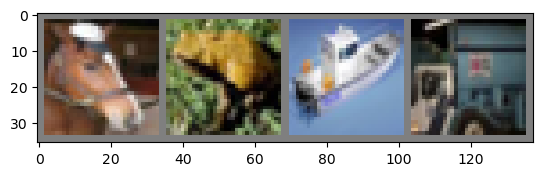

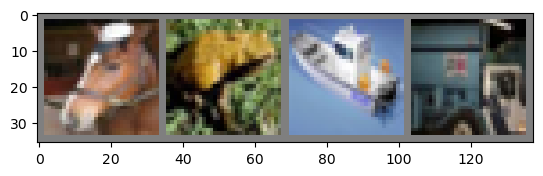

In [32]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [33]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.492020934547759, train acc: 0.47048021681347973
 val loss: 1.2569954948222384, val acc: 0.5513519505237011

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.1697617460866296, train acc: 0.5914729695215521
 val loss: 1.0695989626519224, val acc: 0.6254210994598713

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.0654030689591683, train acc: 0.6309210956641481
 val loss: 1.0886091442818338, val acc: 0.6294547872340426

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 1.007809752955951, train acc: 0.6531853943899737
 val loss: 1.0497830867767335, val acc: 0.6405363476022761

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 0.9703583078802831, train acc: 0.6636483089579525
 val loss: 1.048000713612171, val acc: 0.638408688027808

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 0.9415245993263761, train acc: 0.6746335531937356
 val loss: 0.9728235173732677, val acc: 0.6547207446808511

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 0.9183855766679077, train acc: 0.6828235179676216
 val loss: 0.9157819288842222, val acc: 0.6801196808510638

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 0.9044886595915179, train acc: 0.6869327828042904
 val loss: 0.9021987788220669, val acc: 0.6874556739279565

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 0.8953494383277579, train acc: 0.6891077958469635
 val loss: 0.9239470438754305, val acc: 0.6880097518575953

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 0.8638979789325917, train acc: 0.7013702990803902
 val loss: 0.8722805740985464, val acc: 0.7018395390916378

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 0.7753510699084734, train acc: 0.7322040677506484
 val loss: 0.8088044449369958, val acc: 0.7204122340425532

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 0.7614948608975524, train acc: 0.7375742688475405
 val loss: 0.8069201858753854, val acc: 0.7265957446808511

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 0.7539778903153959, train acc: 0.7401328676361488
 val loss: 0.8060009843491494, val acc: 0.7261081561129143

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 0.7490612705948148, train acc: 0.7432382803076582
 val loss: 0.7901811944677475, val acc: 0.7299867021276596

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 0.7477348067097952, train acc: 0.7443319078555273
 val loss: 0.78980921405427, val acc: 0.7287234042553191

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 0.732737242303775, train acc: 0.7478861975495514
 val loss: 0.7889232766120992, val acc: 0.7297872340425532

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.7323294054764499, train acc: 0.7484085271083895
 val loss: 0.7826740830502612, val acc: 0.7329343973322118

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.7305534552285614, train acc: 0.7485513516056472
 val loss: 0.7842451911023323, val acc: 0.7277482271194458

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.7274759531674917, train acc: 0.7505264103521595
 val loss: 0.7853826818314005, val acc: 0.7310283688788718

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.7276551799211903, train acc: 0.7507875751315785
 val loss: 0.7823135509135876, val acc: 0.7326906029214251

 lr: [0.0010000000000000002]



Посчитайте точность на тестовой выборке:

In [34]:
print(*test(net, test_loader))

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

0.8001287803528415 0.7209394904458599


Стало лучше но эффект не такой большой каким мог бы быть из-за недообучения.

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

### Без преобразований

Files already downloaded and verified
Files already downloaded and verified


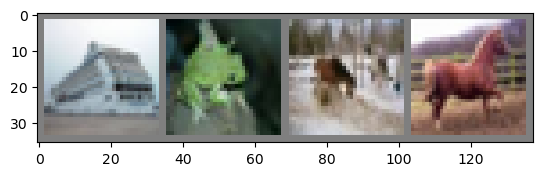

In [62]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

### `ColorJitter`

Случайным образом менят яркость, контраст, насыщенность и тон в заданных пределах.

Files already downloaded and verified
Files already downloaded and verified


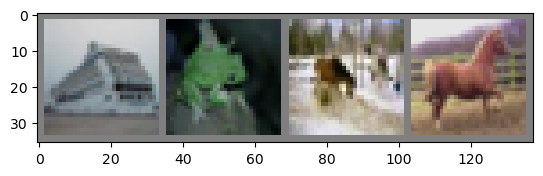

In [63]:
transform = transforms.Compose(
        [transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.2, hue=0.1),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

In [64]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

  0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.6130261122635556, train acc: 0.42456010054844606
 val loss: 1.40826119108403, val acc: 0.5079565603682336

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.3185972342543453, train acc: 0.5379137830498886
 val loss: 1.2080524185870556, val acc: 0.5755762412192974

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.1666718714851785, train acc: 0.5981163489317327
 val loss: 1.2343467689575034, val acc: 0.5771276595744681

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 1.0845532295254947, train acc: 0.6280727670877028
 val loss: 1.0849399820287178, val acc: 0.6283023050490846

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 1.0439604235305646, train acc: 0.6389029446641967
 val loss: 1.0725090582320032, val acc: 0.6248005319148936

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 1.016640118641653, train acc: 0.6500065291821412
 val loss: 1.0096200671601803, val acc: 0.6530363476022761

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 0.990395882665784, train acc: 0.6584739814728662
 val loss: 1.1400984997444965, val acc: 0.6151374114320634

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 0.974139173353394, train acc: 0.6639257965837579
 val loss: 1.0080479710660082, val acc: 0.6519725178150421

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 0.9570500913878027, train acc: 0.6686186015714893
 val loss: 1.028638751456078, val acc: 0.645190602921425

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 0.9412034414368095, train acc: 0.6748906372887997
 val loss: 0.9675365006670039, val acc: 0.6683289007937655

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 0.837276666103377, train acc: 0.7115802103466264
 val loss: 0.8915597682303571, val acc: 0.692974290949233

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 0.8186776733921477, train acc: 0.7174360146252285
 val loss: 0.8793823475533343, val acc: 0.6965868795171697

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 0.8098071047549273, train acc: 0.720590395726931
 val loss: 0.8790194354158767, val acc: 0.6990469859001485

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 0.8058252744853388, train acc: 0.7218105250346377
 val loss: 0.8747200747753712, val acc: 0.7041445037151904

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 0.8013306731388817, train acc: 0.7240100222924074
 val loss: 0.8795887564090972, val acc: 0.6996453901554676

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 0.7879904119580494, train acc: 0.7294087882887511
 val loss: 0.8712449931083841, val acc: 0.7001994680851064

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.7887737102111907, train acc: 0.7248873726977291
 val loss: 0.8701369095355906, val acc: 0.7022384752618506

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.7834952390281112, train acc: 0.7292496409451068
 val loss: 0.8717162033344837, val acc: 0.7041888297872341

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.7844147720873029, train acc: 0.7281927396653993
 val loss: 0.867629029903006, val acc: 0.7040780143534884

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.7851767539433195, train acc: 0.7266543157793705
 val loss: 0.8688334990055003, val acc: 0.7014849292471054

 lr: [0.0010000000000000002]



In [65]:
print(*test(net, test_loader))

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

0.8455713543162984 0.7098925159235668


Стало немного хуже, хз почему.

### `RandomRotation`

Использую случайный поворот вместе с `CenterCrop` и `Resize` для того, чтобы картинки оставались такого же размера и не было паддинга.

Files already downloaded and verified
Files already downloaded and verified


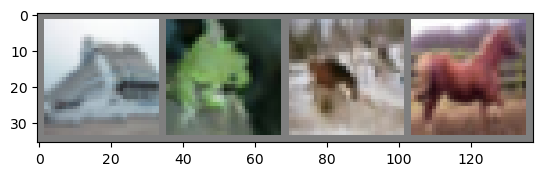

In [83]:
transform = transforms.Compose(
        [transforms.RandomRotation(degrees=10, expand=False),
         transforms.CenterCrop(size=28),
         transforms.Resize(32),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

In [84]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

  0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.5607391061904878, train acc: 0.44321706068363226
 val loss: 1.3852189961900103, val acc: 0.5114804965384463

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.2943824645152258, train acc: 0.5419006268110746
 val loss: 1.2443682604647697, val acc: 0.5667109930768927

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.189540145057211, train acc: 0.5837645273539877
 val loss: 1.1666197561203164, val acc: 0.5918661348363187

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 1.1185589356439858, train acc: 0.6111174588665448
 val loss: 1.1553394241535917, val acc: 0.602437943346957

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 1.0745812872428127, train acc: 0.6221965591693926
 val loss: 1.1418563010844778, val acc: 0.6033687944107867

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 1.050482410181593, train acc: 0.63344704886895
 val loss: 1.07141427790865, val acc: 0.6288342199427016

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 1.0262829779053082, train acc: 0.6430611779310585
 val loss: 1.1201640841808724, val acc: 0.6165780142266699

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 1.0011564083465492, train acc: 0.6514347741547188
 val loss: 1.0370243643192534, val acc: 0.6423315603682336

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 0.9841358939516043, train acc: 0.6590167145624457
 val loss: 1.0225690722465515, val acc: 0.6492464539852548

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 0.9712080105567109, train acc: 0.6634320319243715
 val loss: 1.0008208104904661, val acc: 0.654188829787234

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 0.8713160036250922, train acc: 0.69888923351246
 val loss: 0.9154999920662413, val acc: 0.6871232271194458

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 0.8545997725762222, train acc: 0.7030229825642252
 val loss: 0.9165003768941189, val acc: 0.6904476952045522

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 0.8494789741483859, train acc: 0.7064426091297017
 val loss: 0.9100281484583591, val acc: 0.6880984042553191

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 0.8421291965017371, train acc: 0.709523537477148
 val loss: 0.9090416555709028, val acc: 0.6904698582405739

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 0.837330086902465, train acc: 0.7107355054161448
 val loss: 0.9066660391523483, val acc: 0.6947695037151905

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 0.8231447744957926, train acc: 0.7159261557476176
 val loss: 0.8964968130943624, val acc: 0.6960106382978724

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.8217700768323442, train acc: 0.7154895207781679
 val loss: 0.9013754601174212, val acc: 0.6936170212765957

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.8204273469269384, train acc: 0.7160485767141339
 val loss: 0.9033314877368034, val acc: 0.693594858240574

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.820087104817849, train acc: 0.7175951619688727
 val loss: 0.9028512292719902, val acc: 0.6905363476022761

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.8196646907865675, train acc: 0.7145713633113631
 val loss: 0.9016006905981835, val acc: 0.694126773134191

 lr: [0.0010000000000000002]



In [85]:
print(*test(net, test_loader))

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

1.1004477507749182 0.6559514331210191


Стало хуже, ну тут хотя бы наверное понятно почему, наши преобразоавания скорее всего меняют меняют распределение

### Пробуем уменьшить угол поворота

Files already downloaded and verified
Files already downloaded and verified


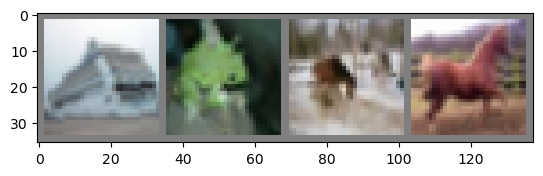

In [86]:
transform = transforms.Compose(
        [transforms.RandomRotation(degrees=5, expand=False),
         transforms.CenterCrop(size=30),
         transforms.Resize(32),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

In [87]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

  0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.5369226276547643, train acc: 0.4538268804332238
 val loss: 1.3466600022417434, val acc: 0.5241799646235527

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.261432786419361, train acc: 0.5576072408250743
 val loss: 1.2418008066238242, val acc: 0.5667553191489362

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.1435966891606069, train acc: 0.600148537477148
 val loss: 1.12797005506272, val acc: 0.6105274824385948

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 1.0751819642195972, train acc: 0.6260528205953525
 val loss: 1.1148552001790797, val acc: 0.6180851063829788

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 1.029190779495065, train acc: 0.6430815813528337
 val loss: 1.038739372060654, val acc: 0.6373670212765957

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 1.0049615278976274, train acc: 0.6497861713552388
 val loss: 1.0057544715861058, val acc: 0.6565602837724889

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 0.9689628502568554, train acc: 0.664737855930433
 val loss: 1.078925985985614, val acc: 0.626440602921425

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 0.9579080283314916, train acc: 0.6671005811072355
 val loss: 0.9973257295628811, val acc: 0.655718085106383

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 0.9356915121540509, train acc: 0.6736011361291248
 val loss: 0.978455406300565, val acc: 0.6582668441407225

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 0.9163517951965332, train acc: 0.6813259010341093
 val loss: 0.9642099618911744, val acc: 0.6665558510638298

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 0.8138299953784978, train acc: 0.7186234983491288
 val loss: 0.8781220661832931, val acc: 0.6972739361702127

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 0.7966731195584947, train acc: 0.72508732699389
 val loss: 0.8732096791267395, val acc: 0.6994237589075211

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 0.7921536053229512, train acc: 0.7254301057873086
 val loss: 0.8698541220198286, val acc: 0.7013741135597229

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 0.7834251522473051, train acc: 0.7299188757945241
 val loss: 0.8641063492348854, val acc: 0.7039007093044037

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 0.7789836315611817, train acc: 0.7290864129171075
 val loss: 0.8666506404572345, val acc: 0.7018395390916378

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 0.7664440944382216, train acc: 0.7344851789134512
 val loss: 0.8589437101749664, val acc: 0.7055851063829788

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.7628472685487004, train acc: 0.7366112236348977
 val loss: 0.8576733038780537, val acc: 0.7056959220703612

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.7642223150682188, train acc: 0.7364602377689299
 val loss: 0.8567580278883589, val acc: 0.7087322696726372

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.7608986062149243, train acc: 0.7358930204642539
 val loss: 0.8577805597731407, val acc: 0.707003546268382

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.761199219789104, train acc: 0.7356481784222548
 val loss: 0.8593308781055694, val acc: 0.7058953901554675

 lr: [0.0010000000000000002]



In [88]:
print(*test(net, test_loader))

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

1.0174243302102302 0.676453025477707


### `RandomResizedCrop`

Делает кроп в случайном месте в заданном диапазоне, а затем растягивает картинку.

Files already downloaded and verified
Files already downloaded and verified


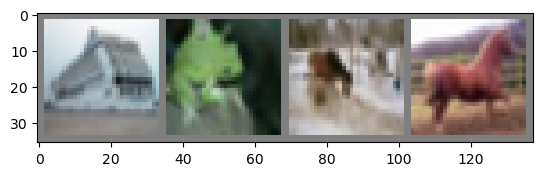

In [94]:
transform = transforms.Compose(
        [transforms.RandomResizedCrop(32, scale=(0.75, 1.0)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

In [96]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

  0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.5871059360626192, train acc: 0.43390082272358743
 val loss: 1.3897772266509685, val acc: 0.5120789007937655

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.3185717446058716, train acc: 0.5370201096892139
 val loss: 1.2385321662781086, val acc: 0.5698803191489362

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.2075207683460367, train acc: 0.5756643379628114
 val loss: 1.1663869725896958, val acc: 0.5918661348363187

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 1.1463468754749193, train acc: 0.5991895730578267
 val loss: 1.121174640858427, val acc: 0.6079565603682335

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 1.1024722130032736, train acc: 0.6149165904936015
 val loss: 1.142593125840451, val acc: 0.5949468085106383

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 1.0857430835964474, train acc: 0.6225964677617144
 val loss: 1.0527505679333464, val acc: 0.6385195037151905

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 1.0439534228724143, train acc: 0.6373318751943613
 val loss: 1.072928215595002, val acc: 0.6277703901554675

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 1.041366979670481, train acc: 0.6385724080328096
 val loss: 1.0512351053826352, val acc: 0.6392065603682335

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 1.0232186499417808, train acc: 0.6450688822613774
 val loss: 1.0441492073079373, val acc: 0.6391400710065314

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 0.9984499624703876, train acc: 0.6509981392942356
 val loss: 1.1986277816143442, val acc: 0.5943927305809995

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 0.9067916470210339, train acc: 0.6871857862149994
 val loss: 0.9484729812500324, val acc: 0.6748226952045522

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 0.8833412768853866, train acc: 0.6931436080383426
 val loss: 0.9407508804443034, val acc: 0.6748226950777337

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 0.8780145252317572, train acc: 0.6953267825586922
 val loss: 0.9388014968405378, val acc: 0.6777260638297873

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 0.8743859300665707, train acc: 0.6939760708067927
 val loss: 0.932043738314446, val acc: 0.683311170212766

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 0.8738182253549914, train acc: 0.6947065161394681
 val loss: 0.9320399078916997, val acc: 0.6820478723404255

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 0.8563227102133212, train acc: 0.7038513646483203
 val loss: 0.9226401280849538, val acc: 0.6808067376309253

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.8555239144801222, train acc: 0.7001297663509083
 val loss: 0.9239779241541599, val acc: 0.6833998228641267

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.8561934071441455, train acc: 0.7017702076727119
 val loss: 0.923695396362467, val acc: 0.6837987590343394

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.8504040688003874, train acc: 0.7050306868945441
 val loss: 0.9175490701452215, val acc: 0.6864804965384463

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.8545650284621572, train acc: 0.7027414142540648
 val loss: 0.9225931149847963, val acc: 0.6854166667512123

 lr: [0.0010000000000000002]



In [97]:
print(*test(net, test_loader))

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

0.9189668795105758 0.6869028662420382


Снова ерунда

### `RandomAdjustSharpness`

Меняет sharpness с определенной вероятностью.

Files already downloaded and verified
Files already downloaded and verified


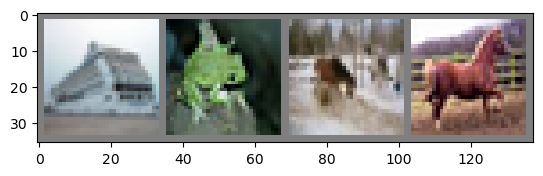

In [98]:
transform = transforms.Compose(
        [transforms.RandomAdjustSharpness(sharpness_factor=2),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

In [99]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

  0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.485151754763706, train acc: 0.47155344093957374
 val loss: 1.311266275923303, val acc: 0.5399822696726373

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.1746676471595137, train acc: 0.5878166623917532
 val loss: 1.1200593111362862, val acc: 0.6084884752618506

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.066117557027876, train acc: 0.6287011948756369
 val loss: 1.081791659365309, val acc: 0.6274822696726373

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 1.0078777194676931, train acc: 0.6514715004228805
 val loss: 1.029823248944384, val acc: 0.6459219859001485

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 0.9700484160313441, train acc: 0.6659579851291734
 val loss: 0.9782563861380232, val acc: 0.6591312057160317

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 0.9507677588863827, train acc: 0.6726136067013854
 val loss: 0.9722967982292176, val acc: 0.6642508866939139

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 0.9241656133636043, train acc: 0.6785673479493401
 val loss: 1.0319830171605373, val acc: 0.6435283688788719

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 0.9078073698816177, train acc: 0.6859615762229375
 val loss: 0.9250920148605996, val acc: 0.6818927305809995

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 0.8848249721570686, train acc: 0.6945963372260169
 val loss: 0.9736715509536419, val acc: 0.6641179079705096

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 0.874587420408207, train acc: 0.6977017498975262
 val loss: 0.9071829377336705, val acc: 0.6820035461415636

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 0.7687473840861695, train acc: 0.7360807325983832
 val loss: 0.8460992244963951, val acc: 0.707535461161999

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 0.749696403360454, train acc: 0.7423160421564985
 val loss: 0.8401143819727797, val acc: 0.7086436170212767

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 0.7447940386300549, train acc: 0.7457927984119116
 val loss: 0.8371407191804114, val acc: 0.7116578014607126

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 0.7371155519372149, train acc: 0.7465436472753284
 val loss: 0.8358424105542771, val acc: 0.7126329787234043

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 0.7339218657130079, train acc: 0.7458172826270081
 val loss: 0.8304885775484937, val acc: 0.7133421986661059

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 0.7181336966358547, train acc: 0.7537215984063785
 val loss: 0.8331887857711061, val acc: 0.7131427305809995

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.7178765840460657, train acc: 0.7556640115690841
 val loss: 0.8262957352273008, val acc: 0.716156914893617

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.7186776613186656, train acc: 0.7536971141912819
 val loss: 0.8264976164127918, val acc: 0.7158466313747649

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.7172739890964202, train acc: 0.7546438365575382
 val loss: 0.8275826172625765, val acc: 0.7148049646235527

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.7146861595144219, train acc: 0.7549172434989887
 val loss: 0.8240756466033611, val acc: 0.7148936170212766

 lr: [0.0010000000000000002]



In [100]:
print(*test(net, test_loader))

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

0.8304851465164476 0.7134753184713376


Ничего не изменилось :(

### Часть из них вместе

Files already downloaded and verified
Files already downloaded and verified


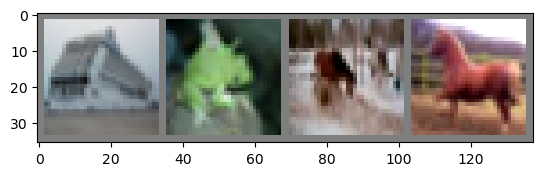

In [101]:
transform = transforms.Compose(
        [transforms.RandomResizedCrop(32, scale=(0.75, 1.0)),
         transforms.RandomHorizontalFlip(),
         transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.1, hue=0.05),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

In [102]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

  0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.6466287803824249, train acc: 0.4124893902424702
 val loss: 1.5253012865147693, val acc: 0.4600177305809995

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.3951572892434854, train acc: 0.5105078023138169
 val loss: 1.358927754645652, val acc: 0.5345523050490846

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.278852475626595, train acc: 0.5532082463095349
 val loss: 1.2671490692077798, val acc: 0.563984929120287

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 1.217560821520999, train acc: 0.5760805694015196
 val loss: 1.297460931666354, val acc: 0.5531471632896585

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 1.1849342337256157, train acc: 0.5877554519084951
 val loss: 1.1864016576016203, val acc: 0.5838874114320634

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 1.153250133969448, train acc: 0.5993976887226976
 val loss: 1.1391696970513527, val acc: 0.6099734042553191

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 1.1297759888812873, train acc: 0.6077468007312614
 val loss: 1.2416309356689452, val acc: 0.5751773050490846

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 1.1071517741004553, train acc: 0.6159979759884054
 val loss: 1.096000018525631, val acc: 0.6214539007937655

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 1.0966234298685134, train acc: 0.6217721664709408
 val loss: 1.1046152847878477, val acc: 0.6149157803109352

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 1.0841328241271555, train acc: 0.6262731784222548
 val loss: 1.0755364514411765, val acc: 0.6300753546522019

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 0.9961089877585388, train acc: 0.65578071955571
 val loss: 0.9942016943972162, val acc: 0.6591755319148936

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 0.9718013812244701, train acc: 0.6624445024966322
 val loss: 0.9880758026812939, val acc: 0.6586436170212766

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 0.9659114010373243, train acc: 0.6659906307129799
 val loss: 0.9764572369291428, val acc: 0.6610150710065315

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 0.9627370995620923, train acc: 0.6667088339925902
 val loss: 0.9730116849249982, val acc: 0.6673315603682335

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 0.9578432773105405, train acc: 0.6691654153454238
 val loss: 0.9680918455123901, val acc: 0.667065602921425

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 0.944421876065256, train acc: 0.672952304810449
 val loss: 0.962566879962353, val acc: 0.6675531914893617

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.9412498526424987, train acc: 0.6732950836038677
 val loss: 0.9660793446479959, val acc: 0.6691489361702128

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.9346894928044768, train acc: 0.6756659702583466
 val loss: 0.9610725235431752, val acc: 0.6679078015875309

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.9430536243117924, train acc: 0.6734256660480604
 val loss: 0.9638114295107253, val acc: 0.6660460994598714

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.9416509234709103, train acc: 0.6746743601462523
 val loss: 0.9636990331588907, val acc: 0.66850620584285

 lr: [0.0010000000000000002]



In [103]:
print(*test(net, test_loader))

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

0.9230219585121058 0.6824243630573248


Мдаа... может это я что-то не так делаю? 

### Эта штука специально для CIFAR10 составлена

Files already downloaded and verified
Files already downloaded and verified


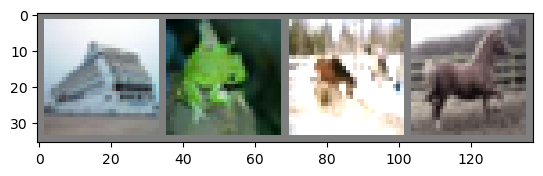

In [107]:
transform = transforms.Compose(
        [transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

In [108]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

  0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.842439030162595, train acc: 0.3426890180359375
 val loss: 1.7061109192827915, val acc: 0.40503102845333994

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.5573033841915933, train acc: 0.456316107369864
 val loss: 1.4590070891887583, val acc: 0.5044769503968827

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.4302310015209414, train acc: 0.5026279707495429
 val loss: 1.4059207322749685, val acc: 0.509375

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 1.3631329523362015, train acc: 0.5290464220578753
 val loss: 1.4751526208634071, val acc: 0.5009751773895101

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 1.329755955248036, train acc: 0.5388401018854033
 val loss: 1.3887119658449862, val acc: 0.5188386525245423

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 1.306934208386123, train acc: 0.5415415252257527
 val loss: 1.3377095511619082, val acc: 0.5314937944107867

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 1.274571231884756, train acc: 0.5575215461267196
 val loss: 1.5102505902026562, val acc: 0.4930851063829787

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 1.261956813457461, train acc: 0.5613696461839693
 val loss: 1.3162523695763122, val acc: 0.5427748227373083

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 1.239360619288694, train acc: 0.5713714416763682
 val loss: 1.3034149996777797, val acc: 0.559751773134191

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 1.22930179762448, train acc: 0.5739953317415561
 val loss: 1.2843638876651196, val acc: 0.5516400710065315

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 1.133585091046921, train acc: 0.6103421258969978
 val loss: 1.160006011800563, val acc: 0.5985815603682335

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 1.118364727584274, train acc: 0.6145003591638597
 val loss: 1.1624694623845688, val acc: 0.5986037234042553

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 1.1118622693544769, train acc: 0.61441058378115
 val loss: 1.13958637004203, val acc: 0.6022163122258288

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 1.1130120096084624, train acc: 0.6170018281535649
 val loss: 1.1410978951352708, val acc: 0.6032358156873825

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 1.1058516088307884, train acc: 0.6187442870201096
 val loss: 1.1358876388123695, val acc: 0.6088652483960415

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 1.0938992837011488, train acc: 0.6223842714124885
 val loss: 1.1311356757549529, val acc: 0.6071365249917863

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 1.0916942555246232, train acc: 0.6264608906653507
 val loss: 1.1220482265695613, val acc: 0.6112810284533399

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 1.0896055530586453, train acc: 0.625
 val loss: 1.1375054671409282, val acc: 0.608222517815042

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 1.0894707057768074, train acc: 0.626636360746415
 val loss: 1.1245504211872182, val acc: 0.611436170212766

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 1.0836394161149396, train acc: 0.6266077958469635
 val loss: 1.1213928823775434, val acc: 0.6094193263256803

 lr: [0.0010000000000000002]



In [109]:
print(*test(net, test_loader))

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

0.8670025718439917 0.6987460191082803


АХААХАХ, ну ясно короче

## Вывод

У нас скорее всего сильное недообучение и поэтому аугментация более сложная чем просто повороты только лишь мешает

# Что делать?

Обучим полностью две модели, с аугментацией и без и посмотрим какая лучше

### С аугментацией

In [110]:
transform = transforms.Compose(
        [transforms.RandomResizedCrop(32, scale=(0.75, 1.0)),
         transforms.RandomHorizontalFlip(),
         transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.1, hue=0.05),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 50, \
    train_loader, val_loader, scheduler, True)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.634781978901823, train acc: 0.41764739488117003
 val loss: 1.4999845454033385, val acc: 0.46646719866610586

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.3484763534674915, train acc: 0.5246759924417875
 val loss: 1.2903681055028389, val acc: 0.5469858156873825

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.2491486939913177, train acc: 0.5656747846324439
 val loss: 1.2165649003170906, val acc: 0.5774157801841168

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 1.1895681700279332, train acc: 0.5847153304045989
 val loss: 1.192852927776093, val acc: 0.5866578015875309

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 1.1576013008244947, train acc: 0.6004301057873086
 val loss: 1.263333501967978, val acc: 0.5719858156873825

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 1.1269523892585713, train acc: 0.6084976495946783
 val loss: 1.1185412919267694, val acc: 0.6151374114320634

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 1.1074175368279382, train acc: 0.6172956386257569
 val loss: 1.0878518206007937, val acc: 0.6259308510638298

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 1.0896987906321747, train acc: 0.6216415840267481
 val loss: 1.0666610225718072, val acc: 0.630474290949233

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 1.0825611947877316, train acc: 0.6255019261370629
 val loss: 1.0850178827630712, val acc: 0.6279698582405739

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 1.0578568421944403, train acc: 0.632671715899403
 val loss: 1.0457918940706457, val acc: 0.6447916667512122

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 1.0435716685255005, train acc: 0.6372216962809101
 val loss: 1.05157469992942, val acc: 0.6386303191489362

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 1.0259176694278962, train acc: 0.6446363280852491
 val loss: 1.038663894064883, val acc: 0.6426196808510638

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 1.031944159288947, train acc: 0.6437426548335409
 val loss: 1.0282364779330315, val acc: 0.6449024824385947

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 1.0170683197173165, train acc: 0.6481702142485317
 val loss: 1.064032953089856, val acc: 0.6396941489361702

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 1.0083270572003324, train acc: 0.6497412837183671
 val loss: 1.093112901170203, val acc: 0.6237588652904997

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 0.9949267670049092, train acc: 0.6561030948183872
 val loss: 1.0029122149690668, val acc: 0.654188829787234

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.9932167033172831, train acc: 0.6560296422820641
 val loss: 1.088271676225865, val acc: 0.6203235816448293

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.9853022169369449, train acc: 0.657310982073029
 val loss: 0.9890738657180299, val acc: 0.6625221632896585

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.977181248625628, train acc: 0.6631667864605975
 val loss: 0.9906398501801998, val acc: 0.6640292553191489

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.9682328248808545, train acc: 0.6640196526508226
 val loss: 1.0065668121297309, val acc: 0.6547429079705096

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20
 train loss: 0.9594504131477537, train acc: 0.6677861386940728
 val loss: 1.0245459239533607, val acc: 0.651529255319149

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 21
 train loss: 0.9592492710083886, train acc: 0.6673617458866545
 val loss: 0.977581037105398, val acc: 0.6657136526513607

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 22
 train loss: 0.9534786803412917, train acc: 0.6684920998116516
 val loss: 1.014739678261128, val acc: 0.6580452127659574

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 23
 train loss: 0.9524290336115486, train acc: 0.6701243797647451
 val loss: 1.002771410282622, val acc: 0.6527703901554676

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 24
 train loss: 0.9481273914603908, train acc: 0.6722626665392567
 val loss: 0.9542781941434171, val acc: 0.6724955675449777

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 25
 train loss: 0.9332923203761224, train acc: 0.6769921977951496
 val loss: 1.0422688519701044, val acc: 0.6469636526513607

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 26
 train loss: 0.9343031316832171, train acc: 0.6788897232120172
 val loss: 0.9539811375293326, val acc: 0.6703014184819891

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 27
 train loss: 0.9278119777412693, train acc: 0.6774941238232461
 val loss: 0.9321906173482855, val acc: 0.6793661348363187

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 28
 train loss: 0.9266791079990171, train acc: 0.6811667537994315
 val loss: 0.945979436407698, val acc: 0.6748005319148936

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 29
 train loss: 0.9273046255111694, train acc: 0.6810116871401423
 val loss: 0.9617588164958548, val acc: 0.6689716313747649

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 30
 train loss: 0.9141283403040068, train acc: 0.682729661900557
 val loss: 0.9416407562316732, val acc: 0.6771941489361702

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 31
 train loss: 0.9226479913896355, train acc: 0.6806525856093035
 val loss: 0.9314269623857864, val acc: 0.6760416667512122

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 32
 train loss: 0.9095458168216336, train acc: 0.684594541733618
 val loss: 0.950657547788417, val acc: 0.6800088654173181

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 33
 train loss: 0.9124444476865109, train acc: 0.6846761557476176
 val loss: 0.9374584984272084, val acc: 0.6779033688788718

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 34
 train loss: 0.9032370669314369, train acc: 0.6898341603863174
 val loss: 0.9878319329403816, val acc: 0.6649601063829788

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 35
 train loss: 0.9076575137797396, train acc: 0.6850311765941013
 val loss: 0.9115692993427845, val acc: 0.6866134752618506

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 36
 train loss: 0.8958369974026514, train acc: 0.6924580504515053
 val loss: 0.950486451260587, val acc: 0.6834884752618505

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 37
 train loss: 0.895751840453697, train acc: 0.6917357665965065
 val loss: 0.9231674455581828, val acc: 0.6841090425531915

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 38
 train loss: 0.8939863318063224, train acc: 0.6915398929847006
 val loss: 0.9282094833698679, val acc: 0.6828900710065314

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 39
 train loss: 0.8966157852622665, train acc: 0.6910134826325411
 val loss: 0.9932995590757816, val acc: 0.6601728723404255

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 40
 train loss: 0.8252176946434286, train acc: 0.7179624249773879
 val loss: 0.8516069227076591, val acc: 0.7090425531914893

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 41
 train loss: 0.8082882306475526, train acc: 0.7225450509427016
 val loss: 0.8469420932708902, val acc: 0.7086214539852548

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 42
 train loss: 0.8082253427348581, train acc: 0.7213942935959294
 val loss: 0.8526379709548139, val acc: 0.7108377659574469

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 43
 train loss: 0.8001978505790996, train acc: 0.7246139658652451
 val loss: 0.8378974171394997, val acc: 0.7142730497299357

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 44
 train loss: 0.8027013420404856, train acc: 0.7250628428877599
 val loss: 0.8334939629473584, val acc: 0.7175088654173182

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 45
 train loss: 0.7991239513514029, train acc: 0.7269522069359174
 val loss: 0.8400272110675243, val acc: 0.7110593973322118

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 46
 train loss: 0.792897687588139, train acc: 0.7264502807988545
 val loss: 0.8287197457983139, val acc: 0.7159352837724888

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 47
 train loss: 0.7883697763984339, train acc: 0.7309390506971035
 val loss: 0.8354688045826364, val acc: 0.7156693263256804

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 48
 train loss: 0.7958408007892002, train acc: 0.7269644489889825
 val loss: 0.8348222780734935, val acc: 0.7145390071767441

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 49
 train loss: 0.7943591433534675, train acc: 0.7268665122375628
 val loss: 0.8398709380880315, val acc: 0.7157358156873824

 lr: [0.010000000000000002]



In [111]:
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 50, \
    train_loader, val_loader, scheduler, True)

  0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 0.7915658440297875, train acc: 0.7274296487489174
 val loss: 0.8396958754417744, val acc: 0.7187056739279565

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 0.7863372634599152, train acc: 0.7314124119347148
 val loss: 0.8298140231599199, val acc: 0.7162234042553192

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 0.7843847169082823, train acc: 0.7293271742747515
 val loss: 0.8267492687448542, val acc: 0.7156693263256804

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 0.7832787206883405, train acc: 0.7313634435045218
 val loss: 0.8238751794429535, val acc: 0.7215868795171697

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 0.7867169435760875, train acc: 0.7289599112662363
 val loss: 0.8257300937429387, val acc: 0.7177748228641266

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 0.7844085737490785, train acc: 0.7316001240688442
 val loss: 0.8238293987639407, val acc: 0.7224512412192974

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 0.7840162165313141, train acc: 0.7298331810961693
 val loss: 0.8266613255155847, val acc: 0.7221409574468085

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 0.7830833457614648, train acc: 0.7302412510572012
 val loss: 0.8361934025236901, val acc: 0.7160239361702128

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 0.7809172559808769, train acc: 0.730437124669007
 val loss: 0.8234762493600236, val acc: 0.7203235816448292

 lr: [0.00010000000000000003]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 0.7786614116846534, train acc: 0.7335017302790333
 val loss: 0.8254340422914384, val acc: 0.7154920212765957

 lr: [0.00010000000000000003]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 0.7753025388695858, train acc: 0.7336078285081296
 val loss: 0.8217435157045405, val acc: 0.7177083335024246

 lr: [0.00010000000000000003]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 0.777239077269922, train acc: 0.7321510186361002
 val loss: 0.8221005853186263, val acc: 0.721564716481148

 lr: [0.00010000000000000003]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 0.7814346677206552, train acc: 0.729629146006687
 val loss: 0.8275655847914676, val acc: 0.7190602837724889

 lr: [0.00010000000000000003]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 0.7816283205963358, train acc: 0.7299066336324925
 val loss: 0.8291447824620186, val acc: 0.7186170212765958

 lr: [0.00010000000000000003]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 0.7809569576322706, train acc: 0.7315756399627141
 val loss: 0.8259295291088997, val acc: 0.720877659574468

 lr: [0.00010000000000000003]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 0.7767477936674951, train acc: 0.733028369041422
 val loss: 0.8136306536958573, val acc: 0.7215203901554675

 lr: [1.0000000000000004e-05]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.7797033116630052, train acc: 0.7317062222979405
 val loss: 0.8333139651633323, val acc: 0.7165115249917863

 lr: [1.0000000000000004e-05]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.7812259597141956, train acc: 0.7307186929791676
 val loss: 0.8262938486768844, val acc: 0.7171764186088075

 lr: [1.0000000000000004e-05]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.7835109268180631, train acc: 0.7318327240577781
 val loss: 0.8253652596727331, val acc: 0.7228280143534883

 lr: [1.0000000000000004e-05]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.7757513599923149, train acc: 0.7340852704300959
 val loss: 0.8285349902954507, val acc: 0.7197916667512123

 lr: [1.0000000000000004e-05]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20
 train loss: 0.770553611586691, train acc: 0.7345912771425473
 val loss: 0.8308875357851069, val acc: 0.7179521276595745

 lr: [1.0000000000000004e-06]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 21
 train loss: 0.7814230311396353, train acc: 0.7314899452643595
 val loss: 0.8234587113907996, val acc: 0.7204343973322117

 lr: [1.0000000000000004e-06]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 22
 train loss: 0.7808516045157172, train acc: 0.7318857730633598
 val loss: 0.8214784179596191, val acc: 0.7208333335024245

 lr: [1.0000000000000004e-06]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 23
 train loss: 0.7821201946879218, train acc: 0.7310614717725862
 val loss: 0.8287999520910547, val acc: 0.7188829787234042

 lr: [1.0000000000000004e-06]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 24
 train loss: 0.7807813892089907, train acc: 0.7325142008512939
 val loss: 0.8238908034689882, val acc: 0.7190381207364671

 lr: [1.0000000000000005e-07]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 25
 train loss: 0.7788138046887937, train acc: 0.7320898081528421
 val loss: 0.8298123278516404, val acc: 0.7168661348363187

 lr: [1.0000000000000005e-07]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 26
 train loss: 0.7824050204409542, train acc: 0.7336404740919361
 val loss: 0.8263091972533693, val acc: 0.7185505319148936

 lr: [1.0000000000000005e-07]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 27
 train loss: 0.7797934481060265, train acc: 0.7342444176647738
 val loss: 0.8315106046960709, val acc: 0.7171542553191489

 lr: [1.0000000000000005e-07]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 28
 train loss: 0.7788619381091276, train acc: 0.7333752286281621
 val loss: 0.8341391035851012, val acc: 0.7164228723404256

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 29
 train loss: 0.7748891473688199, train acc: 0.7348157156538048
 val loss: 0.8223216967379793, val acc: 0.7196365249917862

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 30
 train loss: 0.7788110490363956, train acc: 0.7326774288792933
 val loss: 0.8340349694515796, val acc: 0.7160904255319149

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 31
 train loss: 0.7774743791363139, train acc: 0.7308084683618772
 val loss: 0.8260172656241883, val acc: 0.7177083335024246

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 32
 train loss: 0.7776757955442181, train acc: 0.7333507444130655
 val loss: 0.8256016411679856, val acc: 0.7230718085106383

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 33
 train loss: 0.779601146795632, train acc: 0.731485864471038
 val loss: 0.8340358363821151, val acc: 0.7173758866939138

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 34
 train loss: 0.7798525121137908, train acc: 0.7328896253374856
 val loss: 0.8217034783769162, val acc: 0.7187943263256803

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 35
 train loss: 0.7771394363922872, train acc: 0.733856751125517
 val loss: 0.8168156509703778, val acc: 0.7214539007937655

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 36
 train loss: 0.7810439587838035, train acc: 0.7328243340609061
 val loss: 0.8259411705301163, val acc: 0.7204565603682336

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 37
 train loss: 0.7814222394984208, train acc: 0.7313634435045218
 val loss: 0.8283782603892874, val acc: 0.718594858240574

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 38
 train loss: 0.7829793104850832, train acc: 0.7328080113234859
 val loss: 0.8211661417433556, val acc: 0.7218528369639782

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 39
 train loss: 0.779940344624807, train acc: 0.729347577805493
 val loss: 0.827043420964099, val acc: 0.7181959220703612

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 40
 train loss: 0.7814589802046362, train acc: 0.7338077828042904
 val loss: 0.829522809576481, val acc: 0.7164671986661059

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 41
 train loss: 0.7816646759427226, train acc: 0.7325672499658421
 val loss: 0.8311057293668707, val acc: 0.7187721632896585

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 42
 train loss: 0.7801046594841171, train acc: 0.7323550536166161
 val loss: 0.8316373130108448, val acc: 0.7163563829787234

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 43
 train loss: 0.7806992840287454, train acc: 0.7301351528281049
 val loss: 0.825169755550141, val acc: 0.7188608156873825

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 44
 train loss: 0.7777025311150106, train acc: 0.7324448289993258
 val loss: 0.8267660449159906, val acc: 0.7200576241980208

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 45
 train loss: 0.7818115835215971, train acc: 0.7324040220468092
 val loss: 0.8288511981355383, val acc: 0.7192154255319149

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 46
 train loss: 0.7832622124355497, train acc: 0.7316980609292304
 val loss: 0.8197875999389811, val acc: 0.7255540781832756

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 47
 train loss: 0.7827145453453935, train acc: 0.7301188300906849
 val loss: 0.8290205630850285, val acc: 0.7175531914893617

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 48
 train loss: 0.7794687612292099, train acc: 0.7327223166251313
 val loss: 0.8258083348578595, val acc: 0.7195257093044037

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 49
 train loss: 0.7815510510744517, train acc: 0.7315225908481661
 val loss: 0.8283005795580276, val acc: 0.7169769505237011

 lr: [1.0000000000000005e-08]



In [112]:
print(*test(net, test_loader))

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

0.8050674184872086 0.7290007961783439


### Без аугментации

In [113]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 50, \
    train_loader, val_loader, scheduler, True)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 1.4858705252136566, train acc: 0.47153303740883223
 val loss: 1.2494682748266992, val acc: 0.5527925531914893

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 1.1569454030319368, train acc: 0.595386360746415
 val loss: 1.2187163784148844, val acc: 0.5867464539852548

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 1.0518296302127663, train acc: 0.6344672238804958
 val loss: 1.0343201672777216, val acc: 0.6451684398854033

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 0.9915958435923351, train acc: 0.6554216179159049
 val loss: 1.0320168540832844, val acc: 0.644747340425532

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 0.9525983561327515, train acc: 0.6709323583180987
 val loss: 0.9901159190117045, val acc: 0.6520390071767441

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 0.9236790031140204, train acc: 0.681358546617916
 val loss: 0.9922442644200427, val acc: 0.6571143617021277

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 0.8988964512971463, train acc: 0.6893281535648994
 val loss: 0.9674170717279962, val acc: 0.6668882978723404

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 0.8879559366968911, train acc: 0.6921356751888282
 val loss: 0.9386648127373228, val acc: 0.6835549646235527

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 0.8683109616884583, train acc: 0.6965428310730776
 val loss: 0.9236137438327708, val acc: 0.682779255319149

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 0.842601501908991, train acc: 0.7035167472236117
 val loss: 0.8881325209394414, val acc: 0.6993794327086591

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10
 train loss: 0.8278251155747792, train acc: 0.7125677396653993
 val loss: 0.8985056194853276, val acc: 0.6894060284533399

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11
 train loss: 0.8194807488369114, train acc: 0.7160526573984889
 val loss: 0.9166939727803494, val acc: 0.6865248228641266

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12
 train loss: 0.8064560311585938, train acc: 0.7179012144941298
 val loss: 0.9154440433421034, val acc: 0.6850842199427016

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13
 train loss: 0.7962201458335577, train acc: 0.7237121311358603
 val loss: 0.9007578925883516, val acc: 0.6934175531914893

 lr: [0.1]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14
 train loss: 0.6984706685028739, train acc: 0.7599324236404308
 val loss: 0.8121229813454, val acc: 0.7236037234042553

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15
 train loss: 0.681993070969416, train acc: 0.7669430661680929
 val loss: 0.8126550747993144, val acc: 0.7232047872340426

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16
 train loss: 0.6758053156205026, train acc: 0.7683753918250257
 val loss: 0.8066545339340859, val acc: 0.726063829787234

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17
 train loss: 0.671833969284891, train acc: 0.7689426091297017
 val loss: 0.8142218549200829, val acc: 0.7244459220703612

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18
 train loss: 0.6670083032011768, train acc: 0.7716889201614059
 val loss: 0.806732225798546, val acc: 0.7249335106382979

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19
 train loss: 0.6644241432821075, train acc: 0.7726274811589522
 val loss: 0.8028463371256565, val acc: 0.7279920212765958

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20
 train loss: 0.6627233602120192, train acc: 0.7743903435562385
 val loss: 0.8045484877647238, val acc: 0.726063829787234

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 21
 train loss: 0.6597035052680447, train acc: 0.773859852519724
 val loss: 0.8060234016560494, val acc: 0.7277039007937655

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 22
 train loss: 0.6596827315238102, train acc: 0.7730314704356289
 val loss: 0.8031563563549772, val acc: 0.7287234042553191

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 23
 train loss: 0.6549471754587547, train acc: 0.7764551776854604
 val loss: 0.8017147166931883, val acc: 0.7287234042553191

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 24
 train loss: 0.6546258562443679, train acc: 0.7768836511772337
 val loss: 0.8058878056546475, val acc: 0.7262189718002968

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 25
 train loss: 0.6529559938192804, train acc: 0.7765449530681701
 val loss: 0.8072230612978022, val acc: 0.7282801420130628

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 26
 train loss: 0.6501113649805024, train acc: 0.7753819535593663
 val loss: 0.8118717568985959, val acc: 0.7298537234042554

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 27
 train loss: 0.6474323395837159, train acc: 0.7792749412534877
 val loss: 0.8099410462886729, val acc: 0.7291445037151905

 lr: [0.010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 28
 train loss: 0.6331561771127816, train acc: 0.7827435362491573
 val loss: 0.7971431033408388, val acc: 0.7302748228641267

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 29
 train loss: 0.6310788449138348, train acc: 0.7840820058390253
 val loss: 0.7958723187446595, val acc: 0.7289450356300841

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 30
 train loss: 0.6289274059440362, train acc: 0.7859550470407963
 val loss: 0.7965280619073422, val acc: 0.7297429079705097

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 31
 train loss: 0.6314898864987564, train acc: 0.7839718269255741
 val loss: 0.7966573081117996, val acc: 0.7298093973322117

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 32
 train loss: 0.6298799865642457, train acc: 0.7852001176019909
 val loss: 0.79714870047062, val acc: 0.7298758866939139

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 33
 train loss: 0.6285689438827731, train acc: 0.7847308370487346
 val loss: 0.7972826189183174, val acc: 0.7304078015875309

 lr: [0.0010000000000000002]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 34
 train loss: 0.6263422341625695, train acc: 0.7853674263143452
 val loss: 0.7978807486118155, val acc: 0.7315381207364671

 lr: [0.00010000000000000003]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 35
 train loss: 0.6267192391525457, train acc: 0.7868772853009226
 val loss: 0.7970381962492111, val acc: 0.7313386526513607

 lr: [0.00010000000000000003]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 36
 train loss: 0.6267597186608985, train acc: 0.7860978715380541
 val loss: 0.7963751545611848, val acc: 0.729942376055616

 lr: [0.00010000000000000003]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 37
 train loss: 0.6269538463578581, train acc: 0.7874200183905021
 val loss: 0.7958589920338164, val acc: 0.7305407803109352

 lr: [0.00010000000000000003]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 38
 train loss: 0.6268036157927958, train acc: 0.7865589907226005
 val loss: 0.7968860291420146, val acc: 0.730474290949233

 lr: [1.0000000000000004e-05]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 39
 train loss: 0.626091105628493, train acc: 0.78628558378115
 val loss: 0.7975280869514384, val acc: 0.7306072696726373

 lr: [1.0000000000000004e-05]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 40
 train loss: 0.6259081459023617, train acc: 0.7868038326556329
 val loss: 0.7976642234528318, val acc: 0.7320035462683819

 lr: [1.0000000000000004e-05]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 41
 train loss: 0.6262956416912009, train acc: 0.7866650888427302
 val loss: 0.7976373111948054, val acc: 0.7314716313747649

 lr: [1.0000000000000004e-05]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 42
 train loss: 0.6268938021969316, train acc: 0.7871139658652451
 val loss: 0.79702235016417, val acc: 0.7307402483960416

 lr: [1.0000000000000004e-06]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 43
 train loss: 0.6248292653826516, train acc: 0.7872812745775993
 val loss: 0.7966453207300065, val acc: 0.7312721632896586

 lr: [1.0000000000000004e-06]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 44
 train loss: 0.6261582287944432, train acc: 0.7857183664764739
 val loss: 0.7977814679450177, val acc: 0.7304078015875309

 lr: [1.0000000000000004e-06]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 45
 train loss: 0.6266413863332877, train acc: 0.7867793484405364
 val loss: 0.7961895467119015, val acc: 0.7306737590343394

 lr: [1.0000000000000004e-06]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 46
 train loss: 0.6266819300228761, train acc: 0.7855306543423445
 val loss: 0.7964160732766415, val acc: 0.7300753547790203

 lr: [1.0000000000000005e-07]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 47
 train loss: 0.6257986109261103, train acc: 0.7870935623345036
 val loss: 0.7975275393496168, val acc: 0.7313386526513607

 lr: [1.0000000000000005e-07]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 48
 train loss: 0.6252043473873103, train acc: 0.7862692609347635
 val loss: 0.7973771399640023, val acc: 0.7296099292471053

 lr: [1.0000000000000005e-07]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 49
 train loss: 0.627412442533364, train acc: 0.7873506464295675
 val loss: 0.797708657447328, val acc: 0.7312056739279564

 lr: [1.0000000000000005e-07]



In [114]:
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 10, \
    train_loader, val_loader, scheduler, True)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0
 train loss: 0.6270459811364929, train acc: 0.7860244190017309
 val loss: 0.7984017408908681, val acc: 0.7318705675449777

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1
 train loss: 0.6255734757923774, train acc: 0.7869017695160191
 val loss: 0.7971674182313554, val acc: 0.7300088654173181

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2
 train loss: 0.6268788843093887, train acc: 0.7863059873118915
 val loss: 0.7962692456042513, val acc: 0.7306737590343394

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3
 train loss: 0.6258425838986524, train acc: 0.7879341865806301
 val loss: 0.7972294692029345, val acc: 0.7317375888215735

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4
 train loss: 0.6261511429245337, train acc: 0.7870119483205039
 val loss: 0.7985611007568684, val acc: 0.7312056739279564

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5
 train loss: 0.6259655984598714, train acc: 0.7853143771997971
 val loss: 0.7970668398319407, val acc: 0.7308732271194458

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6
 train loss: 0.6265568454261236, train acc: 0.785563299926151
 val loss: 0.7959840148053271, val acc: 0.7311391845662543

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7
 train loss: 0.6256022096443002, train acc: 0.7870364325356004
 val loss: 0.7965659589209455, val acc: 0.7288120569066798

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8
 train loss: 0.6256691620053495, train acc: 0.7875424393570183
 val loss: 0.7971147506795031, val acc: 0.7303413122258288

 lr: [1.0000000000000005e-08]



Training:   0%|          | 0/547 [00:00<?, ?it/s]

Testing:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9
 train loss: 0.6263411472767755, train acc: 0.7876566989548246
 val loss: 0.7963540654233161, val acc: 0.7302083335024245

 lr: [1.0000000000000005e-08]



In [115]:
print(*test(net, test_loader))

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

0.8109772691301479 0.7226313694267515


## Окончательный вывод

Аугментация достаточно неплохо работает, но тестировать это на недообучиных моделях - не всегда хорошая идея.

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

## Пиу-пиу-пиу

Код интегрирован в само задание 2.1, [ссылка](https://wandb.ai/sumimmanis-personal/dl_hw_2?nw=nwusersumimmanis) на wandb.